In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np

In [2]:
# Reading datasets from two different time periods

# https://data.lacity.org/Public-Safety/Crime-Data-from-2010-to-2019/63jg-8b9z
past_df = pd.read_csv("Crime_Data_from_2010_to_2019.csv", dtype = {"TIME OCC": str})
# https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8
present_df = pd.read_csv("Crime_Data_from_2020_to_Present.csv", dtype = {"TIME OCC": str})

LAPD_df = pd.read_csv("LAPD_Police_Stations.csv")

# past dataset has column name typo
past_df = past_df.rename(columns={"AREA ": "AREA"})

# Both datasets use the same columns 
df = pd.concat([past_df, present_df])

In [3]:
# Dropping code columns since these are internal use and we don't get much 
# value from them given we have their description in a seperate column
df = df.drop(columns=[
    "Crm Cd", "Crm Cd 1", "Crm Cd 2", "Crm Cd 3", 
    "Crm Cd 4", "Premis Cd", "Weapon Used Cd", 
    "Mocodes", "Part 1-2", "Status", "Date Rptd"
])

# Changed code to be readable description
df["Vict Descent"] = df["Vict Descent"].replace({
                            "A": "Other Asian", 
                            "B": "Black", 
                            "C": "Chinese", 
                            "D": "Cambodian", 
                            "F": "Filipino", 
                            "G": "Guamanian", 
                            "H": "Hispanic/Latin/Mexican", 
                            "I": "American Indian/Alaskan Native", 
                            "J": "Japanese", 
                            "K": "Korean", 
                            "L": "Laotian", 
                            "O": "Other", 
                            "P": "Pacific Islander", 
                            "S": "Samoan", 
                            "U": "Hawaiian", 
                            "V": "Vietnamese", 
                            "W": "White", 
                            "X": "Unknown", 
                            "Z": "Asian Indian",
                        })

# Renamed X,Y to Longitude, Latitude
LAPD_df = LAPD_df.rename(columns={
    "X": "Longitude", 
    "Y": "Latitude"
})

In [23]:
LAPD_df.head()

,Longitude,Latitude,OBJECTID,DIVISION,LOCATION,PREC
0,-118.289242,33.757661,1,HARBOR,2175 JOHN S. GIBSON BLVD.,5
1,-118.275394,33.938627,2,SOUTHEAST,145 W. 108TH ST.,18
2,-118.277670,33.970307,3,77TH STREET,7600 S. BROADWAY,12
3,-118.419842,33.991655,4,PACIFIC,12312 CULVER BLVD.,14
4,-118.305142,34.010575,5,SOUTHWEST,1546 MARTIN LUTHER KING JR. BLVD.,3


<AxesSubplot: xlabel='Longitude', ylabel='Latitude'>

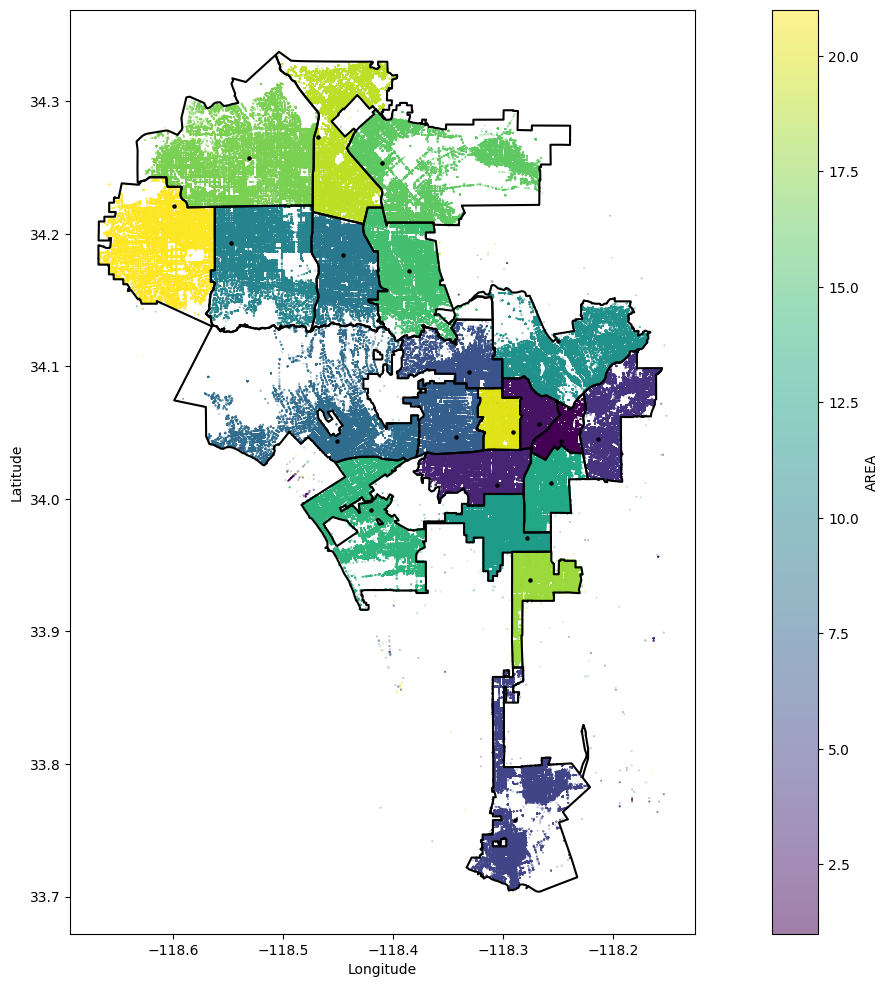

In [136]:
# https://geohub.lacity.org/datasets/031d488e158144d0b3aecaa9c888b7b3_0/explore?location=33.985210%2C-118.389876%2C11.32

map_df = gpd.read_file('LAPD_Divisions.shp')
df_plot = df.loc[(df['LAT'] >= 33.7) & (df['LAT'] <= 34.37) & (df['LON'] >= -118.7) & (df['LON'] <= -118.15)]

fig, ax = plt.subplots(1, figsize = (20, 12))
map_df.boundary.plot(color='black', ax=ax)
df_plot.plot(ax=ax, x='LON', y='LAT', kind='scatter', c='AREA',  s=0.1, alpha=0.5, cmap='viridis')
LAPD_df.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', s=5, c='black')

<AxesSubplot: >

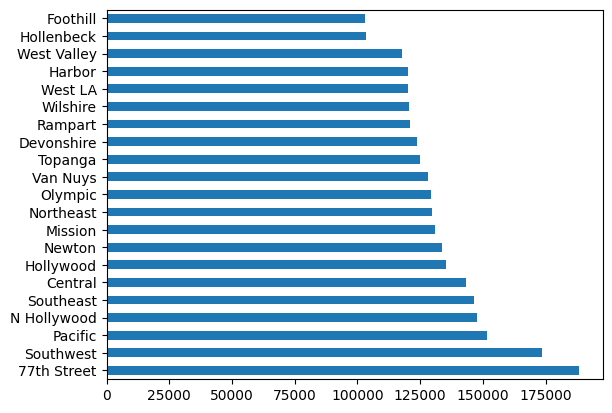

In [135]:
df["AREA NAME"].value_counts().plot(kind="barh")

#  Failed bubble chart version of bar chart. Bubbles are too similar in size
# fig, ax = plt.subplots(1, figsize = (20, 12))
# map_df.boundary.plot(color='black', ax=ax)
# crime_counts = LAPD_df.merge(df.groupby('AREA')[['DR_NO']].count().rename(columns={'DR_NO':'CRIME_COUNT'}), left_on='PREC', right_on='AREA')
# crime_counts['CRIME_COUNT_NORM'] = crime_counts['CRIME_COUNT'] / crime_counts['CRIME_COUNT'].max() * 1000
# crime_counts.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', s='CRIME_COUNT_NORM')

While there are a few with less and a few with more it seems that there are similar amounts of crime commited in each precint.

But based on our map we know that the precint's are not all the same size, so can the differences in numbers of crime commited be related to size?

<AxesSubplot: ylabel='APREC'>

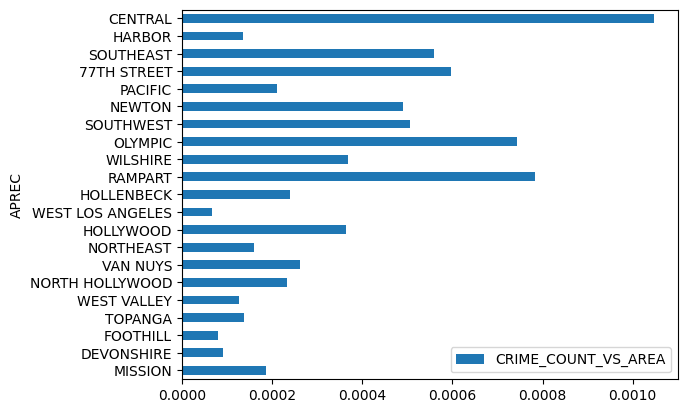

In [74]:
crime_counts = map_df.merge(df.groupby('AREA')[['DR_NO']].count().rename(columns={'DR_NO':'CRIME_COUNT'}), left_on='PREC', right_on='AREA')

crime_counts['CRIME_COUNT_VS_AREA'] = crime_counts['CRIME_COUNT'] / crime_counts['AREA']
crime_counts.plot(kind='barh', x='APREC', y='CRIME_COUNT_VS_AREA')

array([[<AxesSubplot: title={'center': 'Number of Crimes Committed'}, ylabel='APREC'>,
        <AxesSubplot: title={'center': 'Area of Precinct'}, ylabel='APREC'>,
        <AxesSubplot: title={'center': 'Number of Crimes Committed/ Area'}, ylabel='APREC'>]],
      dtype=object)

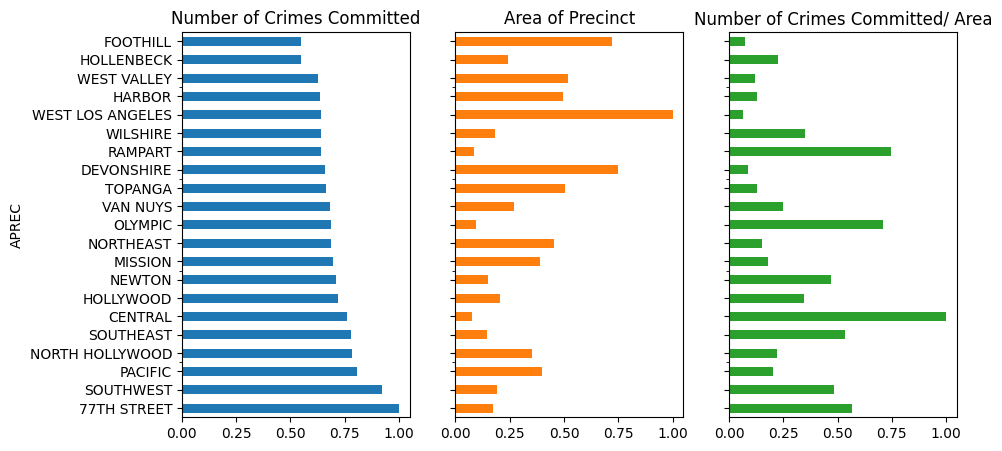

In [131]:
crime_counts['scaled_AREA'] = crime_counts['AREA'] / crime_counts['AREA'].max()
crime_counts['scaled_CRIME_COUNT'] = crime_counts['CRIME_COUNT'] / crime_counts['CRIME_COUNT'].max()
crime_counts['scaled_CRIME_COUNT_VS_AREA'] = crime_counts['CRIME_COUNT_VS_AREA'] / crime_counts['CRIME_COUNT_VS_AREA'].max()
crime_counts.plot(
    kind='barh', 
    x='APREC', 
    y=['scaled_CRIME_COUNT','scaled_AREA','scaled_CRIME_COUNT_VS_AREA'], 
    subplots=True, layout=(1,3), 
    figsize=(10, 5), 
    sharex=True, sharey=True,
    legend=False,
    title=['Number of Crimes Committed', 'Area of Precinct', 'Number of Crimes Committed/ Area']
)

All of the values have been scaled  
The first bar chart is just the number of crimes commited in each area.  
The second is the area of each precint.  
The last bar chart is the number of crimes / the area of the precinct.  
Since the axis are aligned each corresponds to the same area. So despite having an average number of crimes commited, the Central precinct has a very small area compared to the others and gets a higher value on the right bar chart. Since the bars on the right are not all the same size, then that means there is a disparity between the size of a precint and the number of crimes commited there.

In [142]:
centers = np.array([[-1.18202412e+02,  3.40753286e+01],
       [ 5.25801624e-13, -5.04485342e-13],
       [-1.18461281e+02,  3.42230463e+01],
       [-1.18302622e+02,  3.39936897e+01],
       [-1.18601724e+02,  3.41904818e+01],
       [-1.18285614e+02,  3.37677701e+01],
       [-1.18335864e+02,  3.40952508e+01],
       [-1.18406091e+02,  3.39663343e+01],
       [-1.18385725e+02,  3.41820770e+01],
       [-1.18267568e+02,  3.40953106e+01],
       [-1.18439597e+02,  3.40460484e+01],
       [-1.18270494e+02,  3.39478499e+01],
       [-1.18303895e+02,  3.40552667e+01],
       [-1.18435758e+02,  3.42798210e+01],
       [-1.18258001e+02,  3.40377909e+01],
       [-1.18306827e+02,  3.42563790e+01],
       [-1.18558057e+02,  3.42445728e+01],
       [-1.18524802e+02,  3.41872730e+01],
       [-1.18447000e+02,  3.41671587e+01],
       [-1.18361917e+02,  3.40384393e+01],
       [-1.18473954e+02,  3.40013793e+01]])

centers_df = pd.DataFrame(centers, columns=['Longitude', 'Latitude'])

map_df = gpd.read_file('LAPD_Divisions.shp')
df_plot = df.loc[(df['LAT'] >= 33.7) & (df['LAT'] <= 34.37) & (df['LON'] >= -118.7) & (df['LON'] <= -118.15)]

fig, ax = plt.subplots(1, figsize = (20, 12))
map_df.boundary.plot(color='black', ax=ax)
LAPD_df.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', s=5, c='black')
centers_df.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', s=10, c='red')

<AxesSubplot: xlabel='Longitude', ylabel='Latitude'>

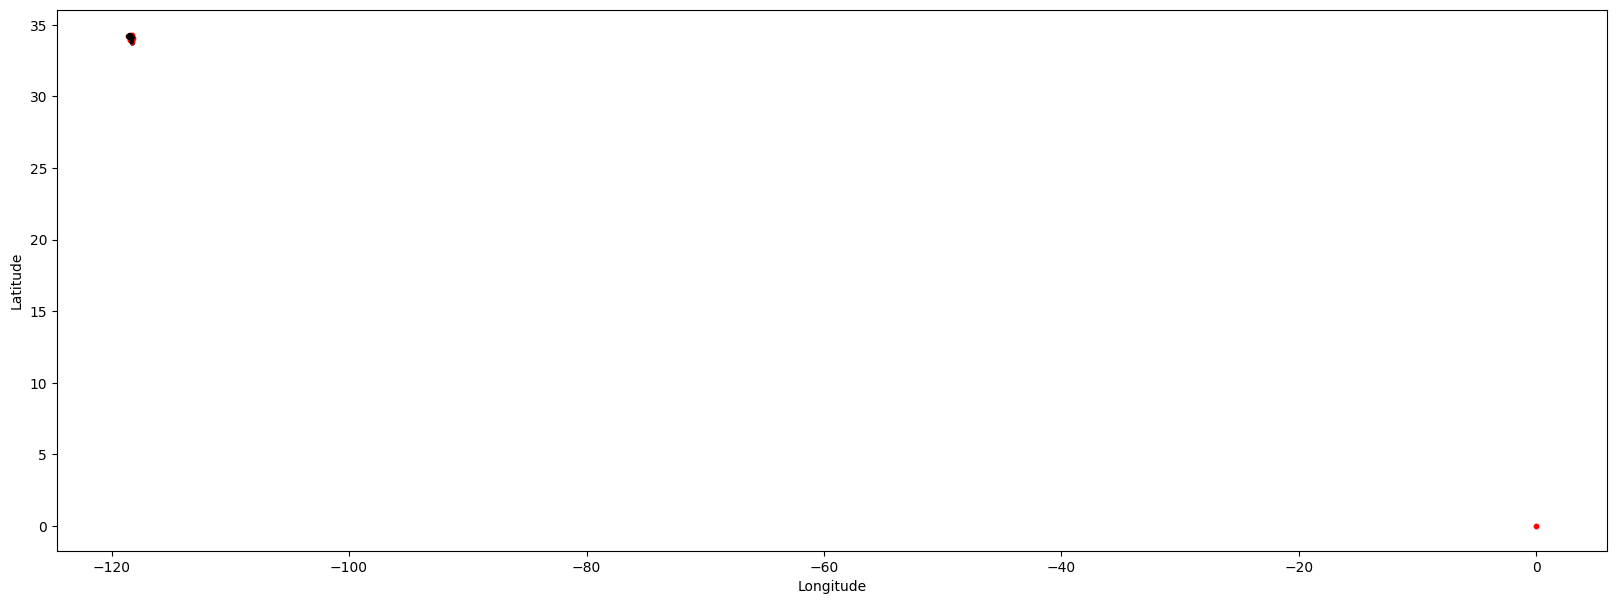